# Principle Component Analysis, Independent Component Analysis, Non-negative Matrix Factorization

## Part I. Theory Overview

Principle Component Analysis(PCA), Independent Component Analysis(ICA) and Non-negative Matrix Factorization(NMF) are fundamental algorithms commonly used to reduce data dimensions in machine learning. We will apply them in different applications to compare and contrast the low dimensional space projected by each algorithm.

### PCA

1. Given observations $\mathbf{X} = (x_1, ..., x_N)$, whitening the data by subtracting the mean, i.e., $\hat{x_i} = x_i - \mu$ where $\mu$ is the global mean.
2. Compute the covariance matrix $\Sigma = \frac{\hat{\mathbf{X}}}{N-1}$, $\hat{\mathbf{X}} = (\hat{x_1}, ..., \hat{x_N})$.
3. Get the eigenvalues $\lambda$ and eigenvectors $\mathbf{V}$ of $\Sigma$.
4. Solve for the feature(projection) matrix $ W_{pca} = \text{diag} (\lambda)^{-1} V^T$.
5. Get the low dimensional representation $Z_{pca} = W_{pca} \hat{X}$.

### ICA

1. Since ICA itself only imposes independence but doesn't reduce dimensionality, we first apply PCA on $X$ to get $W_{pca}$ and $Z_{pca}$.
2. Randomly initialize the weight(projection) matrix $W$ with shape $K\times K$.
3. Update the matrix using iterative rule: $W^{i+1} = W^{i} + \alpha * (I - f(Y)Y^{T}) W^{i}$, where $Y=W^{i}X$, $f()$ can be some non-linear function(e.g., tanh), $I$ is the identity matrix.
4. Get the low dimensional representaion by applying ICA on PCA weights: $Z_{ica} = W Z_{pca}$.
5. Get the synthesis feature matrix as well: $W_{ica} = (W W_{pca})^{+}$.

### NMF

1. Randomly initialize $W_{nmf}$ and $H_{nmf}$.
2. Update the matrix using iterative rule: $W^{i+1}_{nmf} = \frac{W^{i}_{nmf} X H_{nmf}^T}{W^{i}_{nmf} H_{nmf} H_{nmf}^{T}}$, $H^{i+1}_{nmf} = \frac{H^{i}_{nmf} W_{nmf}^T X}{W_{nmf}^{T} W_{nmf} H^{i}_{nmf}}$.

## Part II. Dimensionality Reduction on Audio

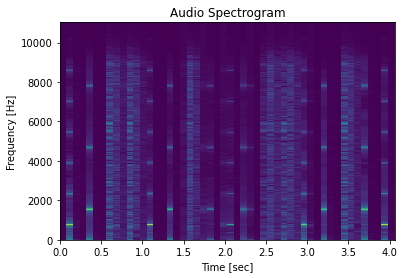

In [1]:
import numpy as np
from scipy import signal
from numpy import linalg as LA
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import warnings
warnings.filterwarnings('ignore')

# Read data and define hyperparameters
fs, x = wavfile.read('vl1.wav')
x = (x/np.max(x)).astype(float)
window = 'hamming'
nperseg = 2048
noverlap = int(1024 * 1/4)

# apply stft and generate spectrogram of the magnitude of the coefficients
f, t, Zxx = signal.stft(x=x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
X = abs(Zxx) # take absolute value of the coefficients
plt.pcolormesh(t, f, np.sqrt(X))
plt.title('Audio Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [2]:
class Model():
    def __init__(self, X):
        self.X = X; # input data of shape (num_feature, num_sample)
        self.fea_dim = X.shape[0] # feature dimension
        self.sam_dim = X.shape[1] # sample dimension
    
    def PCA(self):
        X_mean = np.mean(self.X, axis=1)
        X_norm = self.X-X_mean[:,None] # normalize X to zero mean
        X_cov = (X_norm @ X_norm.T)/(self.sam_dim-1) # compute covariance matrix using matrix multiplication
        w, v = LA.eigh(X_cov)
        w_inverse_sqrt = np.diag(1/(np.sqrt(w)+1e-6)) # add a small number to ensure numerical stability
        # reverse component order since numpy's eigh function returns eigenvalues in ascending order
        self.Wpca = (w_inverse_sqrt @ v.T)                  
        self.Zpca = (self.Wpca @ X_norm)
        self.Wpca = self.Wpca[::-1]
        self.Zpca = self.Zpca[::-1]
        return self.Zpca, self.Wpca
    
    def ICA(self, red_dim, steps=500, lr=1e-3):
        Zred = self.Zpca[:red_dim].astype(float) # First red_dim PCA weight components
        Wred = np.random.random_sample((red_dim, red_dim)) # First red_dim PCA feature components
        # iteratively update the ICA feature matrix
        for step in range(steps):
            fn = 2 * np.tanh(Wred @ Zred)
            Niden = Zred.shape[1] * np.eye(red_dim)
            Wred += lr * (Niden - fn @ (Wred @ Zred).T) @ Wred
        self.Zica = Wred @ Zred
        self.Wica = LA.pinv(Wred @ self.Wpca[:red_dim, :])
        return self.Zica, self.Wica
    
    def NMF(self, red_dim, steps=500):
        # randomly initialize W an H
        self.Wnmf = np.random.uniform(low=0, high=1, size=(self.fea_dim, red_dim))
        self.Hnmf = np.random.uniform(low=0, high=1, size=(red_dim, self.sam_dim))
        # iteratively update W and H
        for step in range(steps):
            self.Wnmf *= (self.X @ self.Hnmf.T)/(self.Wnmf @ self.Hnmf @ self.Hnmf.T + 1e-6) # add a small number to ensure numerical stability
            self.Hnmf *= (self.Wnmf.T @ self.X)/(self.Wnmf.T @ self.Wnmf @ self.Hnmf + 1e-6)
        return self.Wnmf, self.Hnmf
    
# run the model and generate components
model1 = Model(X)
Zpca1, Wpca1 = model1.PCA()
Zica1, Wica1 = model1.ICA(red_dim=3)
Wnmf1, Hnmf1 = model1.NMF(red_dim=3)

In [3]:
# helper function to plot feature components
def plot_components(components, title, model_name, component_name, x_axis):
    plt.figure(figsize=(15,12))
    plt.suptitle(title, size=16)
    plt.subplot(311)
    plt.plot(components[0])
    plt.ylabel('1st %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.subplot(312)
    plt.plot(components[1])
    plt.ylabel('2nd %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.subplot(313)
    plt.plot(components[2])
    plt.ylabel('3rd %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.show()

### PCA Components

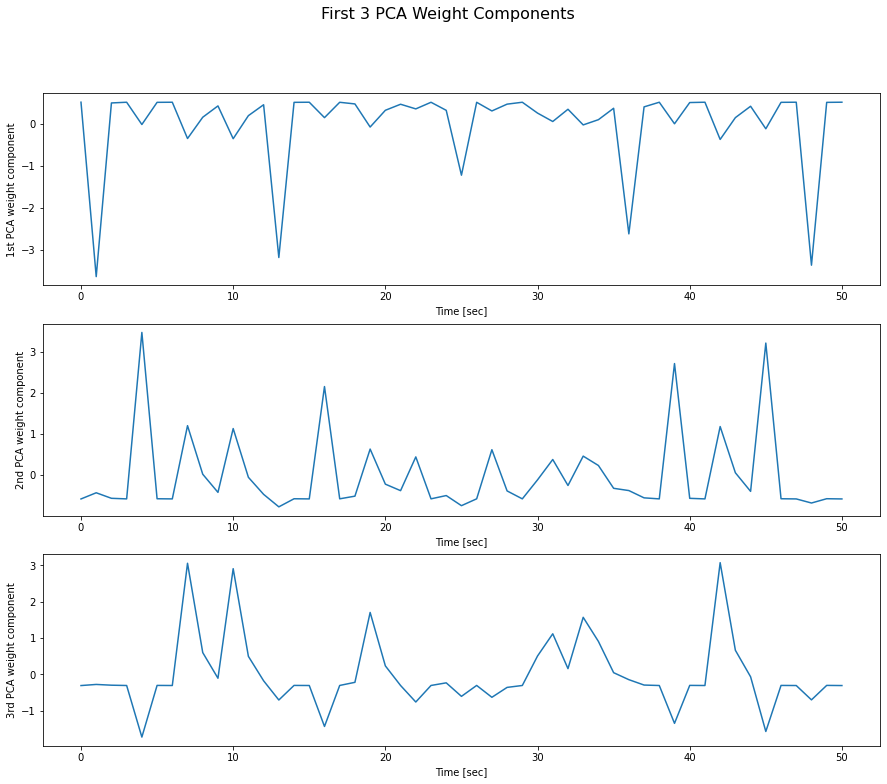

In [4]:
plot_components(Zpca1, 'First 3 PCA Weight Components', 'PCA', 'weight', 'Time [sec]')

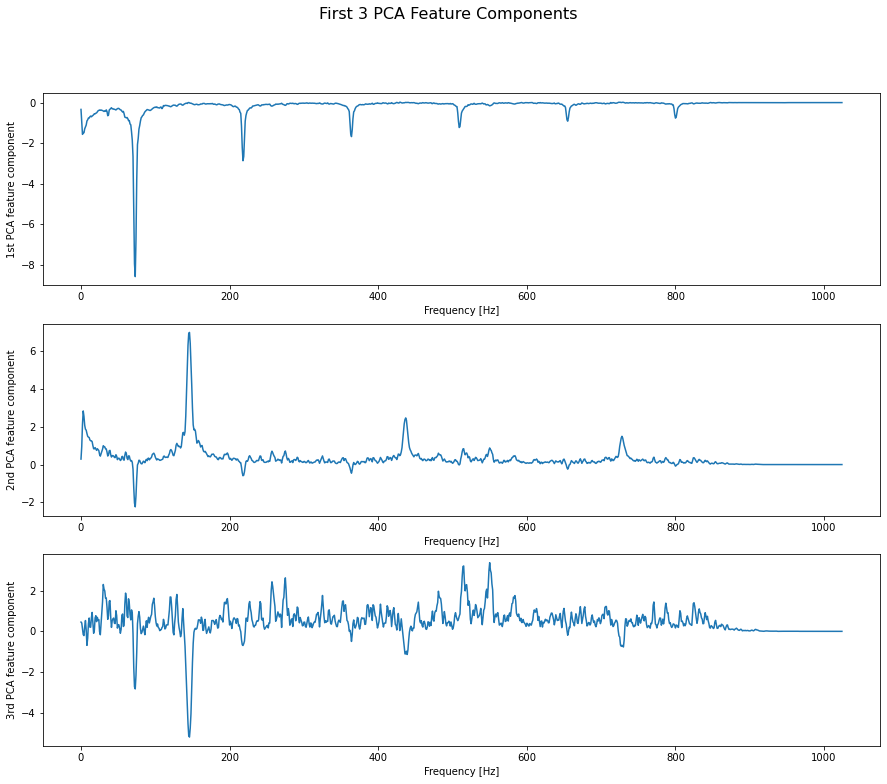

In [5]:
plot_components(Wpca1, 'First 3 PCA Feature Components', 'PCA', 'feature', 'Frequency [Hz]')

As we can see from the above plots, the first three weight components reflect the change of the spectrogram along the time axis. The peaks correspond to the moments when the power of corresponding instrument dominates. The feature components reflect the signal energy at each frequency coefficient. It can be seen that frequency component is associated with the peaks at time: the first component has about 6 peaks along the frequency, the second has about 3, and the third has high energy along the whole frequency band. Note that PCA has order so the components are organized in the order they occur in the time domain.

### ICA Components

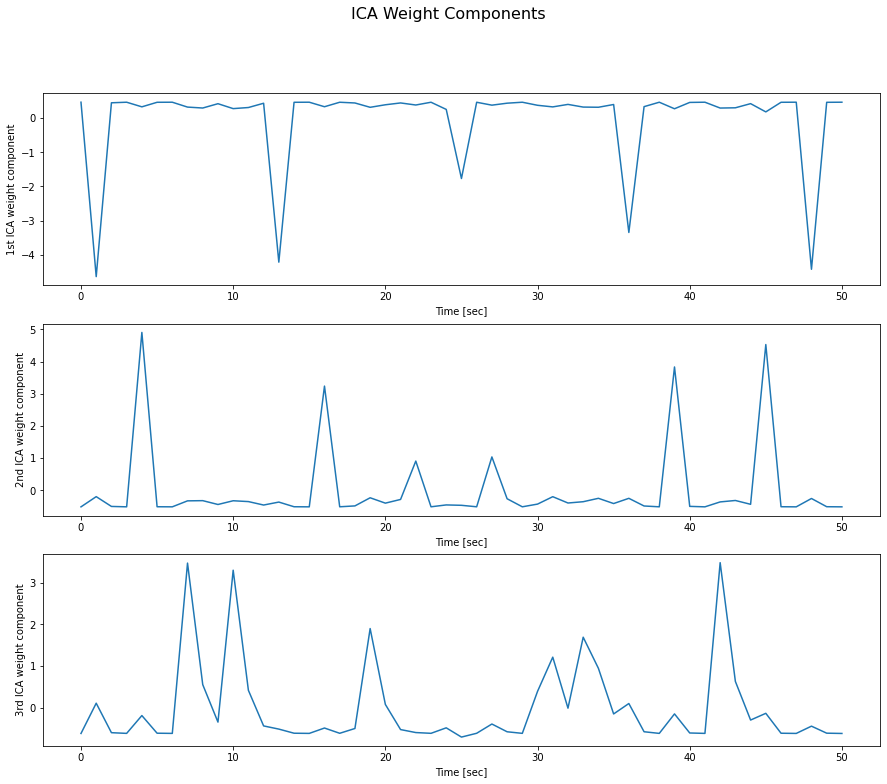

In [6]:
plot_components(Zica1, 'ICA Weight Components', 'ICA', 'weight', 'Time [sec]')

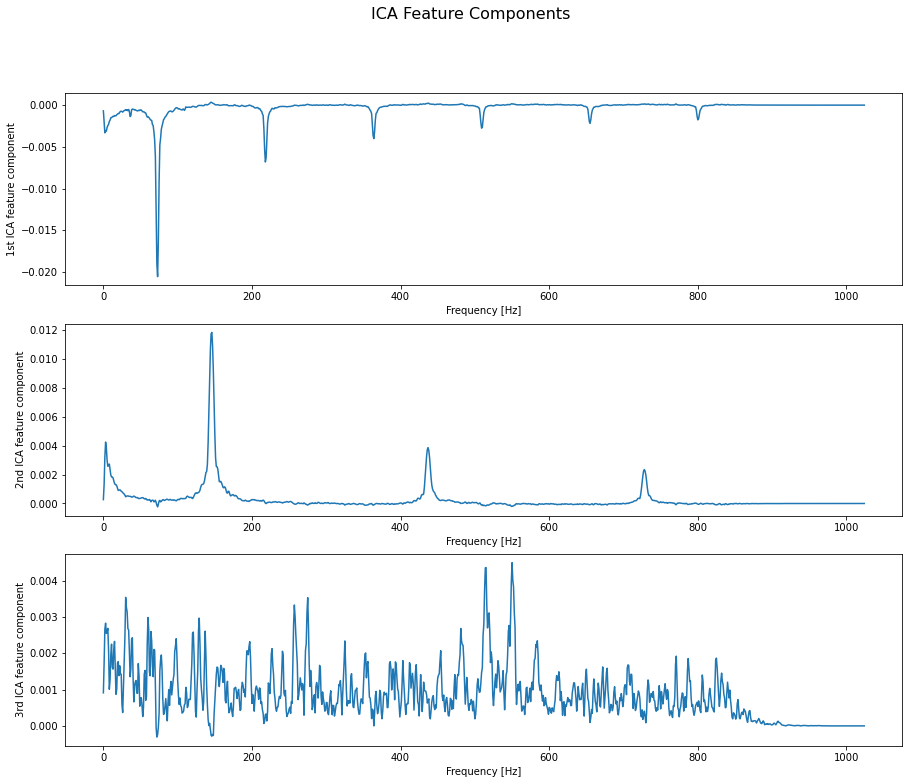

In [7]:
plot_components(Wica1.T, 'ICA Feature Components', 'ICA', 'feature', 'Frequency [Hz]')

The ICA has similar patterns to the PCA. However, since ICA imposes independence, which is stronger than uncorrelation, we can see the peaks are more distinguished. Moreover, ICA does not have any order. So even though the components remain the same, the order are undefined and their positions can change if the algorithm is run again.

### NMF Components

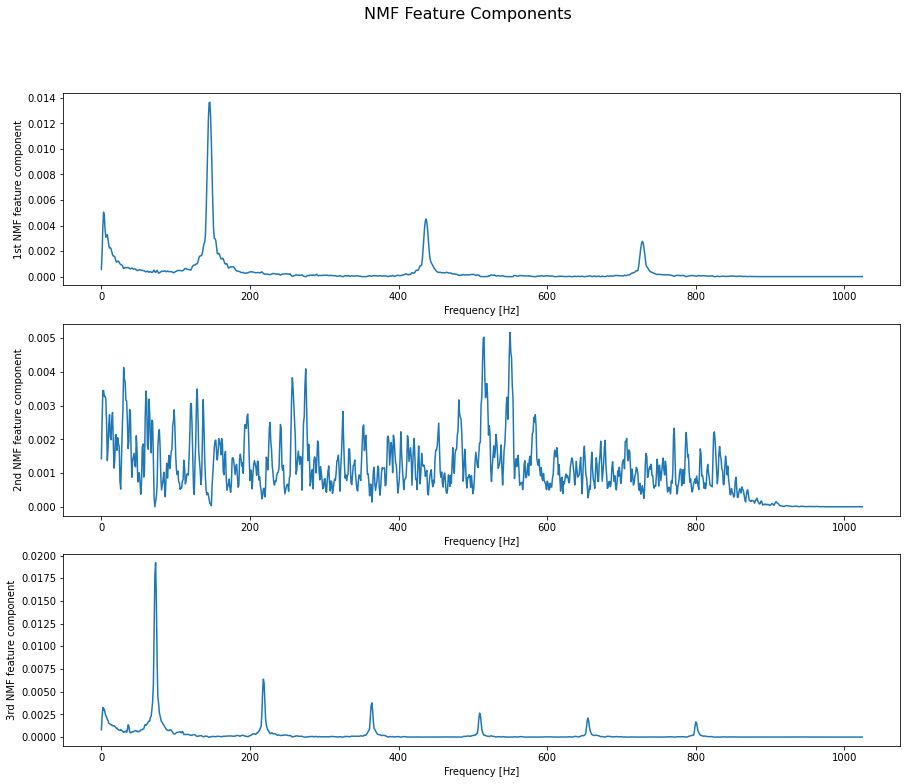

In [8]:
plot_components(Wnmf1.T, 'NMF Feature Components', 'NMF', 'feature', 'Frequency [Hz]')

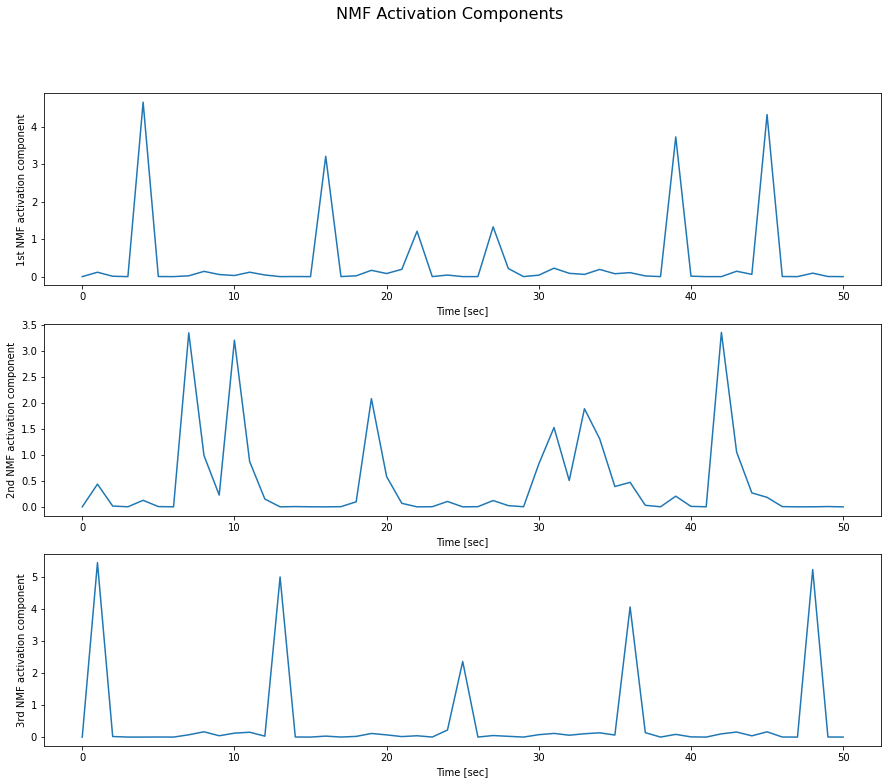

In [9]:
plot_components(Hnmf1, 'NMF Activation Components', 'NMF', 'activation', 'Time [sec]')

From a human's perspective, NMF gives the most intuitive data representation. We can easily tell from the feature matrix which component corresponds to which instrument since the peaks are clearly defined. Also, the activation matrix produces sharp impulses at which a particular instrument dominates and remains flat elsewhere. Moreover, the values are all non-negative, which outperforms PCA and ICA in terms of visualization as the other two sometimes give counter-intuitive negative values. Note that just like ICA, NMF also doesn't have order so their positions may be swapped if we run the model again.

## Part III. Dimensionality on Image

For this part, we again apply PCA, ICA and NMF on handwritten digits. We then reduce the dimensionality to 36 and visualize the data on lower dimensional space.

In [10]:
# read data and label
datafile = np.load('digits-labels.npz')
label = datafile['l']
data = datafile['d']

# run the model
model2 = Model(data)
Zpca2, Wpca2 = model2.PCA()
Zica2, Wica2 = model2.ICA(red_dim=36, lr=1e-6)
Wnmf2, Hnmf2 = model2.NMF(red_dim=36)

In [11]:
# define image plotting function
def plot_images(images, title):
    plt.figure(figsize=(12,12))
    plt.suptitle(title, size=16)
    for num, image in enumerate(images):
        plt.subplot(6,6,num+1)
        plt.axis('off')
        plt.imshow(np.reshape(image,(28,28),'F'))

### PCA Components

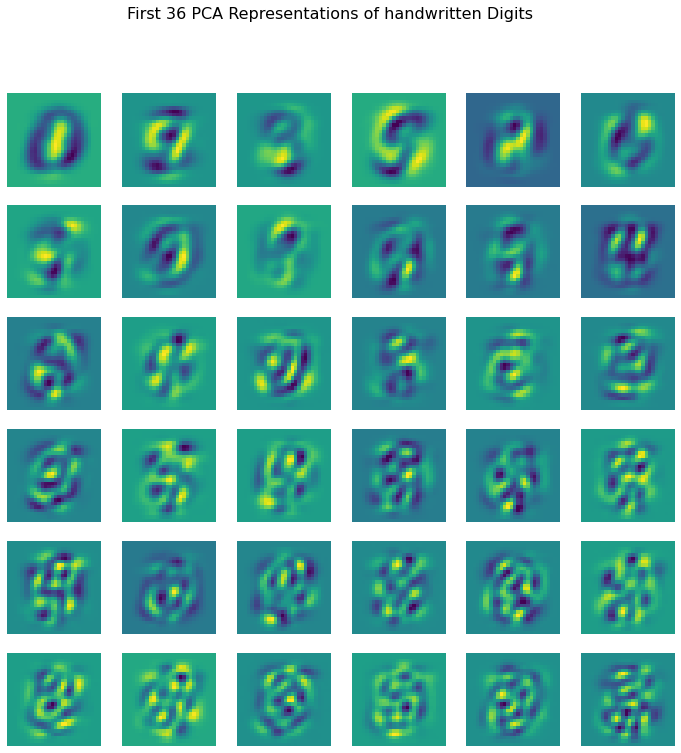

In [12]:
plot_images(Wpca2[:36].astype(float), 'First 36 PCA Representations of handwritten Digits')

When the data becomes images, PCA has a problem in distinguishing the features. For the first images, we may still tell which digit it is. However, as the component weight decreases, it becomes harder and harder to identify the digit.

### ICA Components

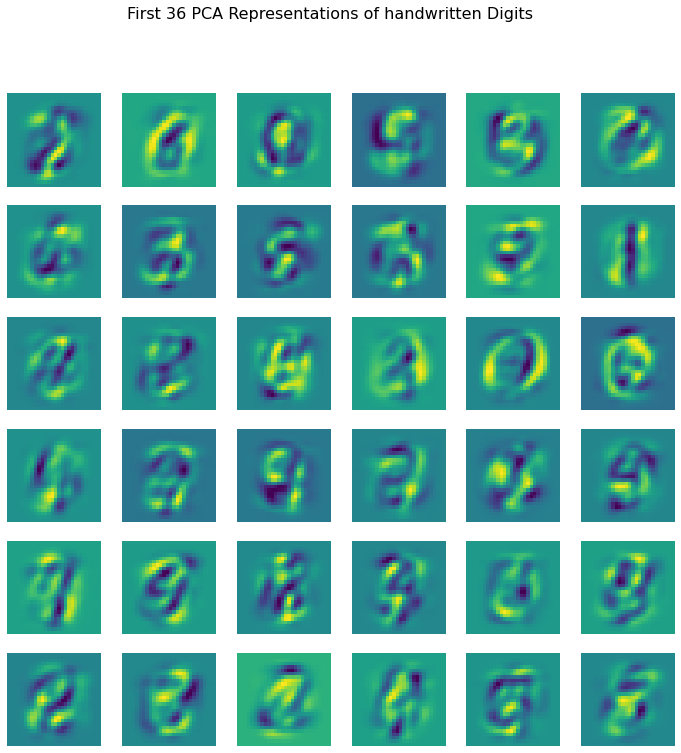

In [13]:
plot_images(Wica2.T[:36].astype(float), 'First 36 PCA Representations of handwritten Digits')

Unlike PCA, ICA imposes feature independence to the data. As a result, we can observe clearer patterns and are able to identity the digits more than a few. In addition, we can see that the digit information such as the strokes are better refined in the center than PCA, displaying the advantages of having independent components.

### NMA Components

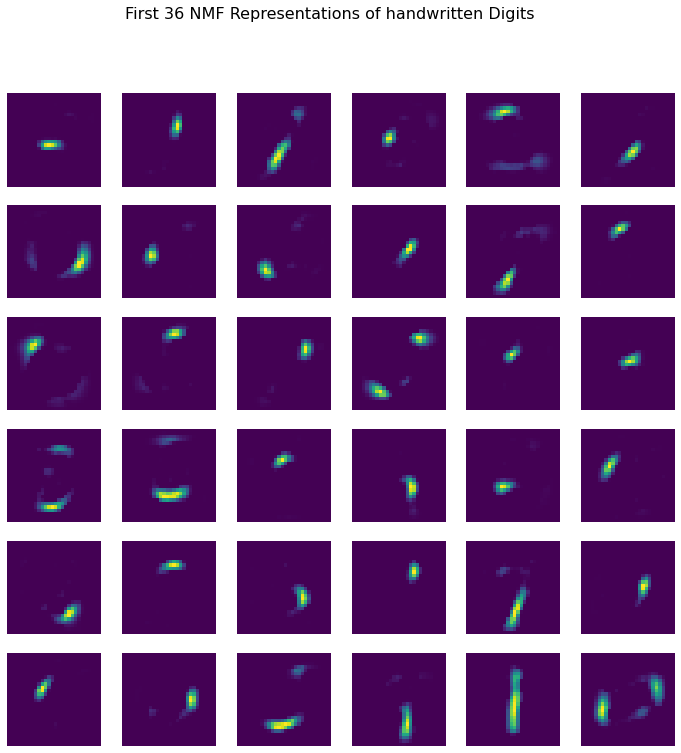

In [14]:
plot_images(Wnmf2.T[:36], 'First 36 NMF Representations of handwritten Digits')

For NMF, we can no longer tell which image represents which digit, but the colors are the most normal among the three. Each image now looks like some strokes of a digit, which are the building blocks of the real images. The NMF output can be intepreted as the lower dimensional representation of the real data, which gives us the most intuitive expression.